## HW02 Code

### Name: Lexi Shewchuk (ashewc01)

You will complete the following notebook, as described in the PDF for Homework 02 (included in the download with the starter code).  You will submit:
1. This notebook file, along with your COLLABORATORS.txt file, to the Gradescope link for code.
2. A PDF of this notebook and all of its output, once it is completed, to the Gradescope link for the PDF.  (This can be generated by printing the notebook as PDF, or using the **File -> Download as** menu.  If you have trouble with the latter, a nice approach is to download in Markdown format, and then use a Markdown reader to print to PDF, which tends to produce nicer results than does printing from a browser.)

In [1]:
# import libraries as needed
import numpy as np
import pandas as pd
import math

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

### Plotting function

**Do not modify the following**: it takes in a list of polynomial (integer) values, along with associated lists consisting of the predictions made for the associated model, and the resulting error, and plots the results in a grid.

In [2]:
def plot_predictions(polynomials=list(), prediction_list=list(), error_list=list()):
    '''Plot predicted results for a number of polynomial regression models
    
    Args
    ----
    polynomials : list of positive integer values
        Each value is the degree of a polynomial regression model.
    prediction_list: list of arrays ((# polynomial models) x (# input data))
        Each array contains the predicted y-values for input data.
    error_list: list of error values ((# polynomial models) x 1)
        Each value is the mean squared error (MSE) of the model with 
        the associated polynomial degree.
    
        Note: it is expected that all lists are of the same length, and 
            that this length be some perfect square (for grid-plotting).
    '''
    length = len(prediction_list)
    grid_size = int(math.sqrt(length))
    if not (length == len(polynomials) and length == len(error_list)):
        raise ValueError("Input lists must be of same length")
    if not length == (grid_size * grid_size):
        raise ValueError("Need a square number of list items (%d given)" % (length))
    
    fig, axs = plt.subplots(grid_size, grid_size, figsize =(14,14), sharey=True)
    for subplot_id, prediction in enumerate(prediction_list):
        # order data for display
        data_frame = pd.DataFrame(data=[x[:, 0], prediction]).T
        data_frame = data_frame.sort_values(by=0)
        x_sorted = data_frame.iloc[:, :-1].values
        prediction_sorted = data_frame.iloc[:, 1].values

        ax = axs.flat[subplot_id]
        ax.set_title('degree = %d; MSE = %.3f' % (polynomials[subplot_id], error_list[subplot_id]))
        ax.plot(x, y, 'r.')
        ax.plot(x_sorted, prediction_sorted, color='blue')
        
    plt.show()

### Load the dataset

In [3]:
data = pd.read_csv('data.csv')
data

,x_i,y_i
0,1.590909,2.846988
1,1.803030,2.959811
2,4.984848,13.041394
3,1.696970,3.971889
4,1.272727,2.454520
...,...,...
95,5.090909,11.537465
96,10.500000,10.381492
97,1.484848,2.683212
98,0.636364,1.437600


In [4]:
x = data.iloc[:, :-1].values
y = data.iloc[:, 1].values

### 1. Test a range of polynomial functions fit to the data

Fit models to data of polynomial degree $d \in \{1, 2, 3, 4, 5, 6, 10, 11, 12\}$.  For each such model, we will record its predictions on the input data, along with the mean squared error (MSE) that it makes.  These results are then plotted for comparison.

#### 1.1 Create function to generate models, make predictions, measure error.

In [5]:
lin_models = list()
def test_polynomials(polynomials=list()):
    '''Generates a series of polynomial regression models on input data.
       Each model is fit to the data, then used to predict values of that
       input data.  Predictions and mean squared error are collected and
       returned as two lists.
    
    Args
    ----
    polynomials : list of positive integer values
        Each value is the degree of a polynomial regression model, to be built.
    
    Returns
    -------
    prediction_list: list of arrays ((# polynomial models) x (# input data))
        Each array contains the predicted y-values for input data.
    error_list: list of error values ((# polynomial models) x 1)
        Each value is the mean squared error (MSE) of the model with 
        the associated polynomial degree.
    '''
    prediction_list = list()
    error_list = list()
   
    # TODO: fill in this function to generate the required set of models,
    #       returning the predictions and the errors for each.
    global lin_models
    lin_models.clear()
    for i in range(len(polynomials)):
        poly_features = PolynomialFeatures(degree=polynomials[i])
        x_transformed = poly_features.fit_transform(x)

        lin_reg = linear_model.LinearRegression()
        lin_reg = lin_reg.fit(x_transformed, y)
        lin_models.append(lin_reg)

        y_predict = lin_reg.predict(x_transformed)
        
        prediction_list.append(y_predict)
        error_list.append(mean_squared_error(y, y_predict))

    return prediction_list, error_list
    

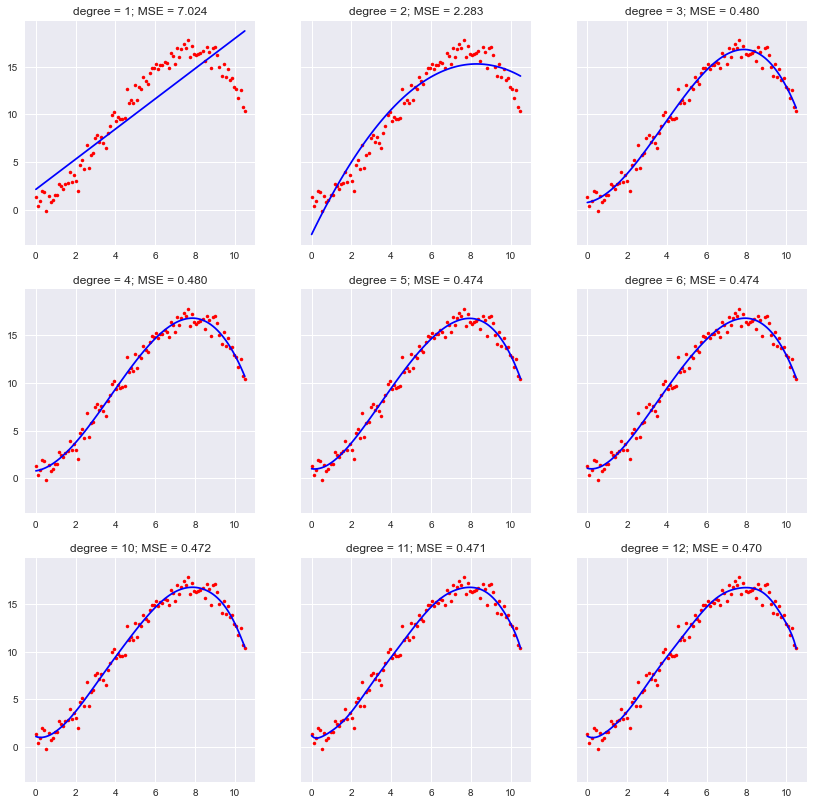

In [6]:
# TODO: generate the sequence of degrees, call test_polynomials to create models,
#       use plot_predictions to show the results
degrees_list = [1,2,3,4,5,6,10,11,12]
pred_list, error_list = test_polynomials(degrees_list)
plot_predictions(degrees_list, pred_list, error_list)

#### 1.2 Discuss the results seen in the plots above

**Discussion**:  The results show that the polynomial regression models have decreasing error as their degree increases. This occurs as the model has more freedom to conform for to the data. While the model decreases error as the degree increases, the model becomes much less generalizable; as seen in the next exercise, a model that's highly optimized to its training data might perform poorly if tested on new data. 

### 2. $k$-fold cross-validation 

For each of the polynomial degrees, 5-fold cross-validation is performed.  Data is divided into 5 equal parts, and 5 separate models are trained and tested.  Results are averaged over the 5 runs and plotted (in a single plot), comparing training and test error for each of the polynomial degrees.  Error values are also shown in a tabular form.

#### Creating the $k$ folds

A function that generates the distinct, non-overlapping folds of the data.  (**Don't modify this.**)

In [7]:
# A simple function for generating different data-folds.
#
# DO NOT MODIFY THIS CODE.
def make_folds(x_data, y_data, num_folds=1):
    '''Splits data into num_folds separate folds for cross-validation.
       Each fold should consist of M consecutive items from the
       original data; each fold should be the same size (we will assume 
       that  the data divides evenly by num_folds).  Every data item should 
       appear in exactly one fold.
       
       Args
       ----
       x_data: input data.
       y_data: matching output data.
           (Expected that these are of the same length.)
       num_folds : some positive integer value
           Number of folds to divide data into.
           
        Returns
        -------
        x_folds : list of sub-sequences of original x_data 
            There will be num_folds such sequences; each will 
            consist of 1/num_folds of the original data, in
            the original order.
        y_folds : list of sub-sequences of original y_data
            There will be num_folds such sequences; each will 
            consist of 1/num_folds of the original data, in
            the original order.
       '''
    x_folds = list()
    y_folds = list()
    
    foldLength = (int)(len(x_data) / num_folds)
    start = 0
    for fold in range(num_folds):
        end = start + foldLength
        x_folds.append(x_data[start:end])
        y_folds.append(y_data[start:end])
        start = start + foldLength
        
    return x_folds, y_folds

In [8]:
# Print out start/end of each fold for sanity check.  Should see 5 folds,
# with the (x,y) pairs at the start/end of each.  (Can be manually verified 
# by looking at original input file.)
#
# DO NOT MODIFY THIS CODE.
k = 5
x_folds, y_folds = make_folds(x, y, k)
for i in range(k):
    print("Fold %d: (%.3f, %.3f) ... (%.3f, %.3f)"
         % (i, x_folds[i][0], y_folds[i][0], x_folds[i][-1], y_folds[i][-1]))

Fold 0: (1.591, 2.847) ... (10.394, 10.739)
Fold 1: (6.788, 16.408) ... (2.227, 4.722)
Fold 2: (9.545, 13.897) ... (3.924, 10.229)
Fold 3: (2.864, 5.929) ... (7.212, 16.030)
Fold 4: (7.530, 16.982) ... (0.848, 0.990)


#### 2.1 Perform cross-validation

For each of the polynomial degrees already considered, $k$-fold cross-validation is performed.  Average training error (MSE) and test error (MSE) are reported, both in the form of a plot and a tabular print of the values.

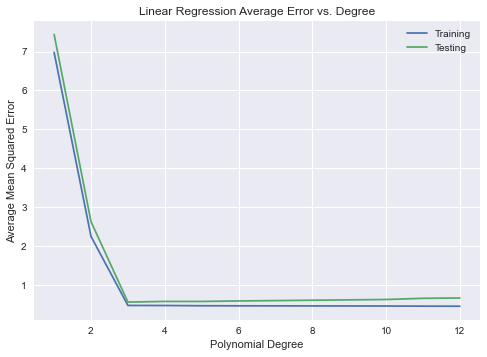

,Degree,Average Training Error,Average Testing Error
0,1,6.977641,7.441157
1,2,2.245920,2.625608
2,3,0.471621,0.558083
3,4,0.469909,0.574623
4,5,0.463663,0.574580
5,6,0.462069,0.586606
6,10,0.457199,0.624748
7,11,0.453294,0.654949
8,12,0.451891,0.662661


In [9]:
# TODO: Perform 5-fold cross-validation for each polynomial degree.  
#       Keep track of average training/test error for each degree; 
#       Plot results in a single table, properly labeled, and also
#       print out the results in some clear tabular format.


# create test and train sets
def get_fold_sets(fold_number, x_folds, y_folds):
    x_test = x_folds[fold_number]
    y_test = y_folds[fold_number]
    
    x_train = list()
    y_train = list()
    for i in range(k):
        if i != fold_number:
            for j in range(len(x_folds[fold_number])):
                x_train.append([x_folds[i][j][0]])
                y_train.append(y_folds[i][j])   
    x_train = np.array(x_train).reshape(len(x_train), 1)
    y_train = np.array(y_train)
      
    return x_train, y_train, x_test, y_test


# get average error for all degrees
avg_train_errors = list()
avg_test_errors = list()
pred = list()

for fold in range(k):
    x_train, y_train, x_test, y_test = get_fold_sets(fold, x_folds, y_folds)
    x = x_train
    y = y_train
    train_error = test_polynomials(degrees_list)[1]
    
    # sum all errors
    for degree in range(len(degrees_list)):
        x_test_transformed = PolynomialFeatures(degree=degrees_list[degree]).fit_transform(x_test)
        y_test_predict = lin_models[degree].predict(x_test_transformed)
        if fold == 0:
            avg_train_errors.append(train_error[degree])
            avg_test_errors.append(mean_squared_error(y_test, y_test_predict))
        else:
            avg_train_errors[degree] += train_error[degree]
            avg_test_errors[degree] += mean_squared_error(y_test, y_test_predict)

# get average of all errors by dividing the sum by k
for i in range(len(avg_train_errors)):
    avg_train_errors[i] /= k
    avg_test_errors[i] /= k

# plot results
plt.plot(degrees_list, avg_train_errors, label='Training')
plt.plot(degrees_list, avg_test_errors, label='Testing')
plt.xlabel('Polynomial Degree')
plt.ylabel('Average Mean Squared Error')
plt.title('Linear Regression Average Error vs. Degree')
plt.legend()
plt.show()

# display results in table

table = {
    'Degree': degrees_list,
    'Average Training Error' : avg_train_errors,
    'Average Testing Error' : avg_test_errors
}
pd.DataFrame(table)

#### 2.2 Discuss the results seen in the plots above

**Discussion:** The results show that as the degree increases, the average training error gets smaller and smaller, while the average testing error decreases until degree=3, then begins to increase. At degree 1 and 2, the model is underfit and thus has a large error for both train and test sets. After degree=3, the model is overfit, so it performs well on training data but increasingly poorly on data is hasn't seen before. Degree 3 minimzes the testing error, and thus balances generalizability and optimization.

### 3. Regularized (ridge) regression

Ridge regularization is a process whereby the loss function that is minimized combines the usual measure (error on the training data) with a penalty that is applied to the magnitude of individual coefficients.  This latter penalty discourages models that overly emphasize any single feature, and can often prevent over-fitting.

Here, a set of 50 different `sklearn.linear_model.Ridge` models are generated, each using a single polynomial degree (the one that was determined to be best for the data-set in earlier tests), and using a range of different regularization penalties, chosen from a logarithmic series: $s \in [0.01, 100]$.  5-fold cross-validation is again used to examine how robust these models are.

#### 4.1 Cross-validation for each regularization strength value

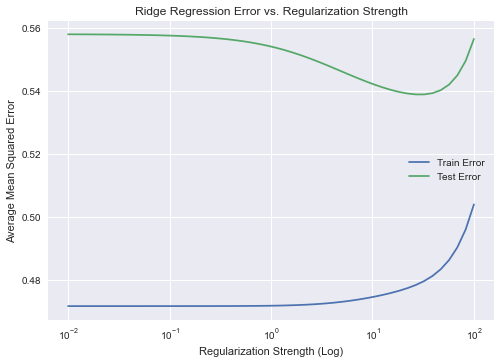

,Regularization Strength,Average Training Error,Average Testing Error
0,0.010000,0.471621,0.558036
1,0.012068,0.471621,0.558026
2,0.014563,0.471621,0.558015
3,0.017575,0.471621,0.558001
4,0.021210,0.471621,0.557984
5,0.025595,0.471621,0.557963
6,0.030888,0.471621,0.557939
7,0.037276,0.471621,0.557909
8,0.044984,0.471621,0.557873
9,0.054287,0.471621,0.557831


In [10]:
# TODO: Generate a sequence of 50 ridge models, varying the regularization strength
#       from 0.01 (10^-2) to 100 (10^2).  Each model is 5-fold cross-validated and
#       the resulting average training/test errors are tracked.  Errors are then
#       plotted (on a logarithmic scale) and printed in some legible tabular form.
best_degree = 3

train_errors = list()
test_errors = list()

reg_strengths = np.logspace(-2, 2, base=10, num=50)

for a in reg_strengths:
    ridge = linear_model.Ridge(alpha=a) 
    fold_train_error = list()
    fold_test_error = list()
    for i in range(k):
        x_train, y_train, x_test, y_test = get_fold_sets(i, x_folds, y_folds)
        x_train_transformed = PolynomialFeatures(degree=best_degree).fit_transform(x_train)
        ridge.fit(x_train_transformed, y_train)
        
        y_train_predict = ridge.predict(x_train_transformed)
        fold_train_error.append(mean_squared_error(y_train, y_train_predict))
        
        x_test_transformed = PolynomialFeatures(degree=best_degree).fit_transform(x_test)
        y_test_predict = ridge.predict(x_test_transformed)
        fold_test_error.append(mean_squared_error(y_test, y_test_predict))
    train_errors.append(sum(fold_train_error) / k)
    test_errors.append(sum(fold_test_error) / k)

#plot results
plt.plot(reg_strengths, train_errors, label="Train Error")
plt.plot(reg_strengths, test_errors, label="Test Error")
plt.xscale('log')
plt.title('Ridge Regression Error vs. Regularization Strength')
plt.xlabel('Regularization Strength (Log)')
plt.ylabel('Average Mean Squared Error')
plt.legend()
plt.show()


# display results in table
table = {
    'Regularization Strength' : reg_strengths,
    'Average Training Error' : train_errors,
    'Average Testing Error' : test_errors
}
pd.DataFrame(table)

#### 4.2 Discuss the results seen in the plots above

**Discussion**:  The results show that the ridge regression model does help to prevent overfitting, and genererates training and testing errors that are much more similar to each than does the polynomial regression model. Additionally, ridge regression at alpha=10^1.43 gives a test error of 0.538, while polynomial is 0.558, so ridge can be more accurate.
As the regularization strength increases, so too does the error (albeit not by much) since the model weights are forced to be so small they approach zero and the penalty continues to increase for a small increase in a weight.